<a href="https://colab.research.google.com/github/nghess/fractal-tools/blob/main/2D_Fractal_Boxcount_Multi_D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2
from os import listdir
from os.path import isfile, join
from google.colab.patches import cv2_imshow
import matplotlib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
mypath = '/content/drive/My Drive/fractal_test_images/multi/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Import and Process Images

In [ ]:
# Import and Process Images
filenames = sorted([f for f in listdir(mypath) if isfile(join(mypath, f))])
images = []

# Iterate through folder
for i in range(len(filenames)):
  image = cv2.imread(mypath+filenames[i], 0)
  # Add image to list
  images.append(image)
  print(f'{filenames[i]} - {np.shape(image)}') # Print filename and dimensions

multi_test.png - (915, 915)


# Box Counting Function

In [224]:
def fractal_dimension(Z, threshold=0.5):

    # Only for 2d image
    assert(len(Z.shape) == 2)

    
    # From https://github.com/rougier/numpy-100 (#87)
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)

        # We count non-empty (0) and non-full boxes (k*k)
        return len(np.where((S > 0) & (S < k*k))[0])

    # Transform Z into a binary array
    Z = (Z < threshold)
    
    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))

    # Extract the exponent
    n = int(np.log(n)/np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2**np.arange(n, 1, -1)

    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))

    # Show image being analyzed 
    matplotlib.pyplot.imshow(Z)

    # Fit the successive log(sizes) with log (counts)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]

##K-Means Image Segmentation 

In [212]:
def img_segment(img, k):
  dims = img.shape # Store 2d shape
  img = np.float32(img.reshape(-1,1)) # Reshape to 1d

  #K-Means steps
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  passes=10
  label = cv2.kmeans(img, k, None, criteria, passes, cv2.KMEANS_PP_CENTERS)[1]
  labeled_img = label.reshape(dims)


  segments = [] # List to store image segments
  
  for segment in np.unique(label):
    mask = np.array([0 if x == segment else 1 for x in label], dtype=object)
    mask = mask.reshape(dims)
    segments.append(mask)

  return segments

In [ ]:
# Run K-means segmentation
labeled = img_segment(images[0],3)

# Show results
for x in range(len(labeled)):
  matplotlib.pyplot.figure()
  matplotlib.pyplot.imshow(np.uint8(labeled[x]))

##Crop Regions

In [140]:
# cropping idea

vec_len = 837225 # 915**2
vec_elem = 513011

def ceildiv(a, b):
    return -(a // -b)

multiplier = ceildiv(vec_elem, 915)

multiplier * 915

513315

# Box Counting Results

multi_test.png: D~1.58
multi_test.png: D~1.00


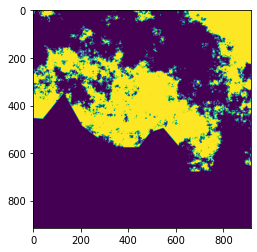

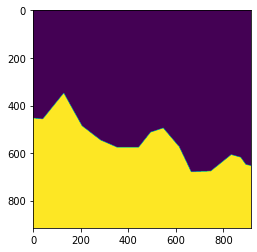

<Figure size 432x288 with 0 Axes>

In [228]:
# Thresholded Images
for i in range(len(labeled)-1):
  D = fractal_dimension(labeled[i])
  matplotlib.pyplot.figure()
  print(f'{filenames[0]}: D~{D:.2f}')